<a href="https://www.kaggle.com/code/robertgrantham/austin-crime-reports-analysis?scriptVersionId=147610372" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analyzing Austin PD's Crime Reports Dataset

The Austin Police Department's Crime Reports dataset provides valuable information about reported crimes in Austin, Texas. In this analysis, we will explore the dataset and gain insights into various aspects of crime in Austin.

## Table of Contents

I. Introduction  
II. Data  
III. Methodology  
IV. Outcome  

## I. Introduction

The Austin Police Department's Crime Reports dataset offers a comprehensive view of reported crimes in Austin, Texas. By analyzing this dataset, we can extract valuable insights into the nature and patterns of crime in the city.

## II. Data

### 1. Project Context

This project is self-paced and not affiliated with any work or educational institution. My goal is to uncover valuable insights that can benefit the Austin law enforcement community, news outlets, and anyone interested in understanding and addressing crime-related issues in the Austin area.

### 2. Data Collection

Initially, I attempted to import the data into this notebook using Sodapy's Socrata API method. However, I found it to be insufficient as it didn't import the complete dataset and added redundant columns. As a result, I decided to manually download the entire dataset and repeat the process each week after the updates.

### 3. Data Scrubbing

Before conducting any analysis, it is crucial to clean and preprocess the dataset. The data scrubbing process involves addressing missing data, removing irrelevant columns, and ensuring data types are appropriate.

## III. Methodology

Once the dataset is scrubbed and prepared, we can perform an exploratory analysis to gain a deeper understanding of the crime data. The exploratory analysis may include the following:

### A. Crime Rates by Area

#### 1. Crime Rates by Zip Code

We start by examining the crime rates by zip code. The following code calculates the total number of crimes for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_by_zipcode = df["zip_code"].value_counts().head(10).to_frame()
display(crime_by_zipcode)
```

#### 2. Crime Rates as Percentages

In addition to the total crime counts, it is also informative to analyze the crime rates as percentages relative to the total. The following code calculates the crime rates as percentages for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_rates_by_zipcode = df["zip_code"].value_counts(normalize=True).head(10).to_frame()
display(crime_rates_by_zipcode)
```

#### 3. Visualizing Crime Rates by Zip Code

To visually represent the crime rates by zip code, we can create a bar chart. The following code generates a bar chart showing the top 10 zip codes with the highest crime rates.

```python
plt.figure(figsize=(10, 6))
crime_by_zipcode.plot(kind="bar", rot=45)
plt.title("Top 10 Zip Codes with Highest Crime Rates")
plt.xlabel("Zip Code")
plt.ylabel("Number of Crimes")
plt.show()
```

## IV. Outcome

In this section, we summarize the key findings and insights obtained from the analysis. Discuss any significant patterns, trends, or observations related to crime in Austin based on the data and methodologies applied.

By analyzing the crime data, we aim to contribute to a better understanding of crime distribution, trends, and areas of concern in Austin. This information can be valuable for law enforcement agencies, policymakers, and the community in efforts to address and prevent crime effectively.

In [1]:
# importing necessary libraries and configurations
import folium
from folium import plugins

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
plt.style.use("seaborn-white")
sb.set_style("whitegrid")


In [2]:
# loading the data
df = pd.read_csv("/kaggle/input/crime-reports-09122023/Crime_Reports.csv")


In [3]:
print(df.head())

   Incident Number  Highest Offense Description  Highest Offense Code  \
0      20072790876          DISTURBANCE - OTHER                  3401   
1      20065065520                FRAUD - OTHER                  1199   
2    2003421480455  CUSTODY ARREST TRAFFIC WARR                  3722   
3      20052602038       DOC UNREASONABLE NOISE                  2405   
4      20065065524                FRAUD - OTHER                  1199   

  Family Violence      Occurred Date Time Occurred Date  Occurred Time  \
0               N  10/05/2007 11:00:00 PM    10/05/2007         2300.0   
1               N  11/14/2006 12:00:00 AM    11/14/2006            0.0   
2               N  05/28/2003 08:16:00 AM    05/28/2003          816.0   
3               N                     NaN    09/17/2005            NaN   
4               N  11/14/2006 12:00:00 AM    11/14/2006            0.0   

         Report Date Time Report Date  Report Time     Location Type  \
0  10/06/2007 11:46:00 AM  10/06/2007       

In [4]:
def clean_data(df):
    """
    Cleans and preprocesses the input DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame to be cleaned.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """
    # List of columns to drop
    drop_col = [
        "Highest Offense Code",
        "Incident Number",
        "Occurred Time",
        "Occurred Date Time",
        "Report Date",
        "Report Time",
        "UCR Category",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df.drop(drop_col, axis=1, inplace=True)

    # Rename columns to lowercase and replace spaces with underscores
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

    # Iterate through columns in fillna_cols and fill missing values
    fillna_cols = [
        "zip_code",
        "location_type",
        "council_district",
        "pra",
        "census_tract",
        "location_type",
        "apd_district",
        "apd_sector",
        "clearance_status",
        "category_description",
    ]
    for col in fillna_cols:
        df[col] = df[col].fillna("Unknown")
    # List of columns to convert to categorical
    cat_cols = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
        "pra",
        "census_tract",
        "category_description",
    ]

    # Replace values in 'family_violence' and 'clearance_status' columns
    df["family_violence"] = df["family_violence"].replace({"Y": "True", "N": "False"})
    df["clearance_status"] = df["clearance_status"].replace(
        {"C": "True", "O": "True", "N": "False"}
    )

    # Convert specified columns to categorical data type
    df[cat_cols] = df[cat_cols].astype("category")

    # Modify the date format for 'occurred_date' column
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y")

    # Extract year, month, and day from 'occurred_date'
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    df["day"] = df["occurred_date"].dt.day

    # Set 'occurred_date' as the index and sort the DataFrame
    df.set_index("occurred_date", inplace=True)
    df.sort_index(inplace=True)
    
    # Ensure 'clearance_date' is in datetime format
    df["clearance_date"] = pd.to_datetime(df["clearance_date"], errors="coerce")
    df["report_date_time"] = pd.to_datetime(df["report_date_time"], errors="coerce")

    # Calculate the mean time to clearance (difference between clearance_date and report_date_time)
    df["time_to_clearance"] = (df["clearance_date"] - df["report_date_time"]).dt.days

    return df


def filter_and_save_data(df, filter_condition, filename):
    """
    Filters the DataFrame based on a filter condition and saves it to a CSV file.

    Args:
        df (DataFrame): Input DataFrame to be filtered.
        filter_condition (str): The condition to filter the DataFrame.
        filename (str): The name of the CSV file to save the filtered data.
    """
    filtered_data = df.query(filter_condition)
    filtered_data.to_csv(filename)


def plot_bar_graph(data, x_label, y_label, title, filename):
    """
    Plots a bar graph from the given data and saves it as an image.

    Args:
        data (Series or DataFrame): Data to be plotted.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title of the plot.
        filename (str): The name of the image file to save the plot.
    """
    plt.figure(figsize=(12, 6), dpi=100)
    data.plot(kind="bar", rot=60)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


def plot_time_series(data, title, x_label, y_label, filename):
    """
    Plots a time series and its 12-month moving average and saves it as an image.

    Args:
        data (Series): Time series data.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        filename (str): The name of the image file to save the plot.
    """
    plt.figure(figsize=(12, 6), dpi=100)
    data.plot(color="red", linewidth=1.5, label="Total per month")
    data.rolling(window=12).mean().plot(
        color="orange", linewidth=2, label="12-month Moving Average"
    )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

    # Clean the data
df = clean_data(df)

# Drop duplicates
df.drop_duplicates(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2406863 entries, 2003-01-01 to 2023-09-09
Data columns (total 20 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   pra                          category      
 10  census_tract                 category      
 11  clearance_status             object        
 12  clearance_date               datetime64[ns]
 13  category_description         category      
 14  latitude                     float64       
 15  longitude                    float

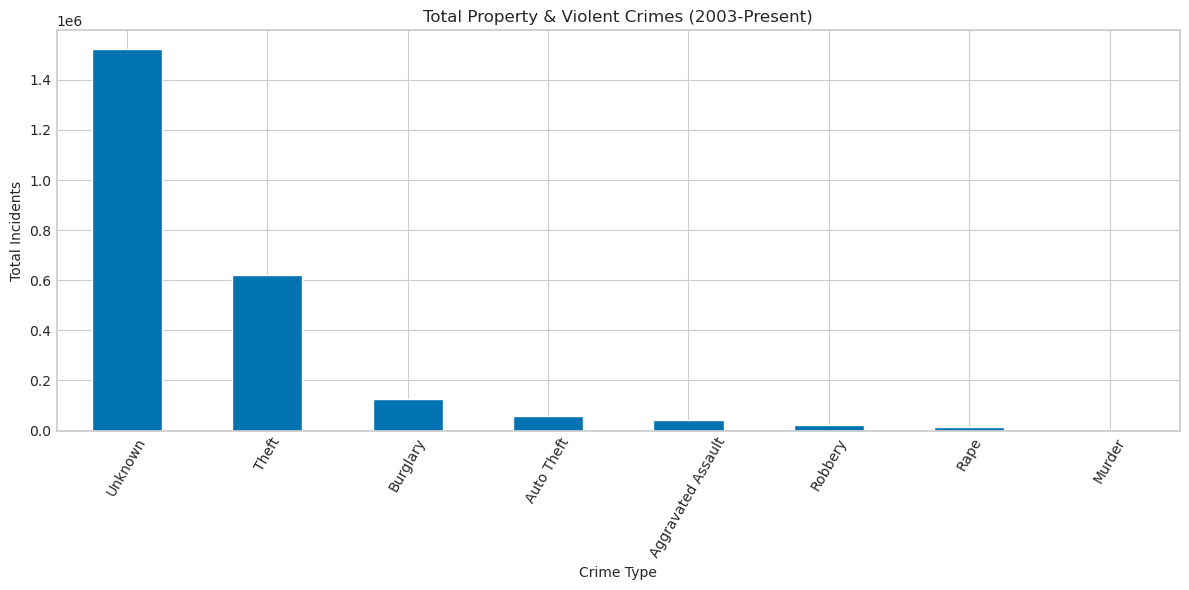

Mean Time to Clearance: 23.65 days


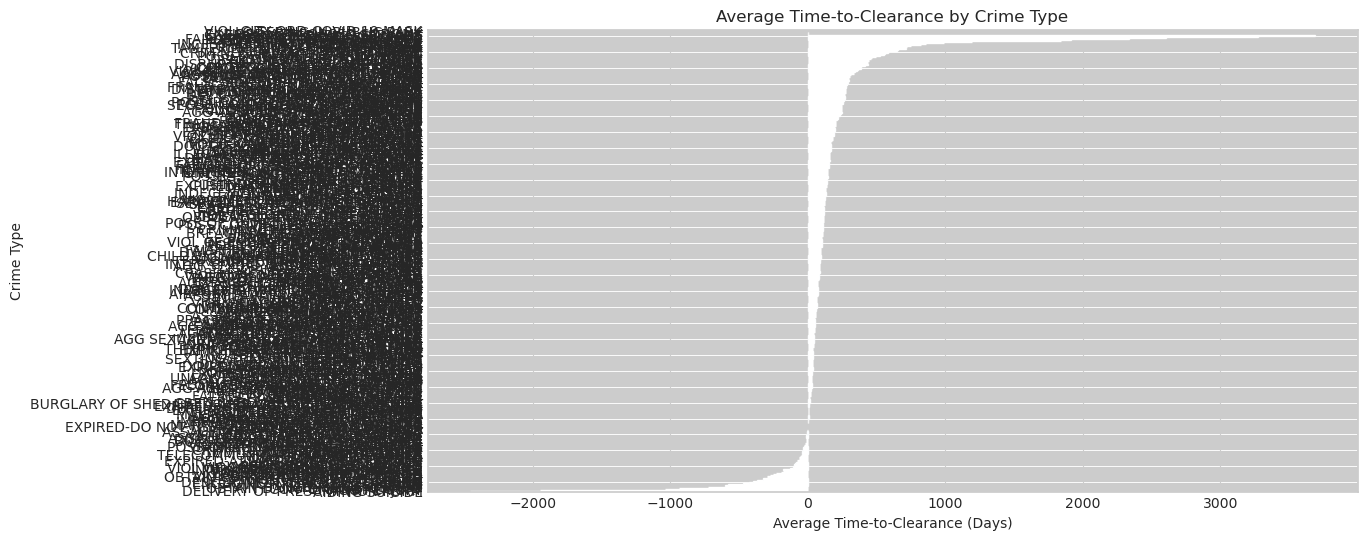

In [5]:
# Re-examine the dataframe
df_info = df.info()

# Set colorblind-friendly palette
sb.set_palette("colorblind")


# Define the filter_by_category function
def filter_by_category(df, categories):
    return df[df["category_description"].isin(categories)]


# Define the filter_by_year function
def filter_by_year(df, year):
    return df[df["year"] == year]


# Plot total property and violent crimes
plot_bar_graph(
    df["category_description"].value_counts(),
    "Crime Type",
    "Total Incidents",
    "Total Property & Violent Crimes (2003-Present)",
    "total_crimes.png",
)

# Calculate the mean time to clearance, excluding rows with NaT values
mean_time_to_clearance = df["time_to_clearance"].mean(skipna=True)
mean_time_to_clearance_message = (
    f"Mean Time to Clearance: {mean_time_to_clearance:.2f} days"
)
print(mean_time_to_clearance_message)

# Create a DataFrame for time-to-clearance by crime type
time_to_clearance_by_type = (
    df.groupby("highest_offense_description")["clearance_date"].mean()
    - df.groupby("highest_offense_description")["report_date_time"].mean()
)

# Convert the Timedelta to integer days
time_to_clearance_by_type_days = time_to_clearance_by_type.dt.days

# Plot the average time-to-clearance by crime type
plt.figure(figsize=(12, 6))
time_to_clearance_by_type_days.sort_values().plot(kind="barh")
plt.title("Average Time-to-Clearance by Crime Type")
plt.xlabel("Average Time-to-Clearance (Days)")
plt.ylabel("Crime Type")
plt.savefig("time_to_clearance_by_type.png")

# Save the mean time to clearance message to a text file
with open("mean_time_to_clearance.txt", "w") as txt_file:
    txt_file.write(mean_time_to_clearance_message)
# Display the plot and save the DataFrame info
plt.show()


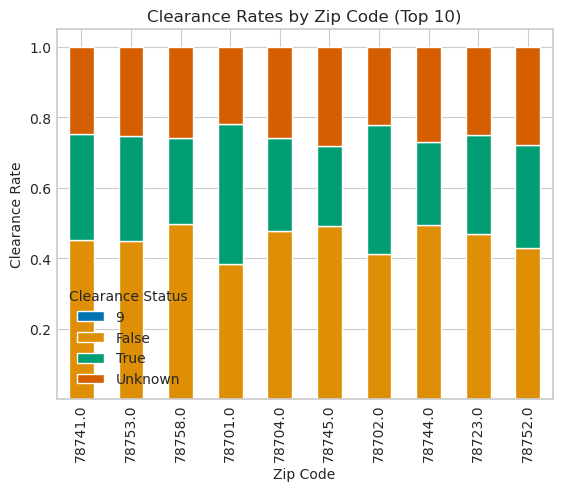

In [6]:
# Calculate clearance rates by zip code
clearance_rates_by_zip = (
    df.groupby("zip_code")["clearance_status"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Plot the clearance rates for the top 10 zip codes
top_10_zip_codes = df["zip_code"].value_counts().head(10).index
ax = clearance_rates_by_zip.loc[top_10_zip_codes].plot(kind="bar", stacked=True)
plt.title("Clearance Rates by Zip Code (Top 10)")
plt.xlabel("Zip Code")
plt.ylabel("Clearance Rate")
plt.legend(title="Clearance Status")

# Save the plot as an image
plt.savefig("clearance_rates_by_zip.png")

# Display the plot
plt.show()


In [7]:
# Create DataFrames for each crime category by filtering the main DataFrame based on category_description
crime_categories = ["Aggravated Assault", "Robbery", "Murder"]
crime_dataframes = {}

for category in crime_categories:
    crime_dataframes[category] = df[df["category_description"] == category]


# Create heat maps for different crime types
def create_heatmap(df, outfile):
    coords_heat = df[["latitude", "longitude"]].dropna()
    map_austin = folium.Map(
        location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12
    )
    map_austin.add_child(plugins.HeatMap(coords_heat.values, radius=15))
    map_austin.save(outfile)


# Create heat maps from the DataFrames
for category, category_df in crime_dataframes.items():
    create_heatmap(category_df, f"{category.lower().replace(' ', '_')}_heatmap.html")



### How is crime distributed in 78701 (downtown Austin)?

### To analyze other zip codes, simply update the 'zip_code' variable accordingly.


### How are violent crimes distributed?

### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors

### Violent crime and murder distribution by location type

### Clearance Analysis

### How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

### Are there any addresses where violent crime and murder occurs frequently?